# Diluted Unitary Fitting, Analysis

In [1]:
import sys
sys.path.insert(0, '../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil
from matplotlib.colors import LinearSegmentedColormap

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde
from quantum_circuits import *
from analysis import *
from utils import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
def resample_diluted(diluted_model, num_samples, rng):
    d = diluted_model.channel.d
    c = diluted_model.channel.c
    rank = diluted_model.channel.rank
    spectrum_resample_list = []
    for i in tqdm(range(num_samples)):
        diluted_resample = DilutedKrausMap(U=generate_haar_random(d, rng=rng), c=c, kraus_part=KrausMap(d, rank = rank))
        spectrum_resample = channel_spectrum(diluted_resample, keep_unity=False)
        spectrum_resample_list.append(spectrum_resample)
    
    spectrum_resample = np.real(np.concatenate(spectrum_resample_list))
    
    return spectrum_resample

path1 = "../../../data/"
path2 = "data/"

In [3]:

[channel_list1, channel_list2, channel_list3, channel_list4, channel_list5, channel_list6, channel_list7] = loader(path1 + "channel_fullRank_belem_longTrain.p")

spectrum_target_list1 = [channel_spectrum(channel) for channel in channel_list1]
spectrum_target_list2 = [channel_spectrum(channel) for channel in channel_list2]
spectrum_target_list3 = [channel_spectrum(channel) for channel in channel_list3]
spectrum_target_list4 = [channel_spectrum(channel) for channel in channel_list4]
#spectrum_target_list5 = [channel_spectrum(channel, keep_unity=False) for channel in channel_list5]
#spectrum_target_list6 = [channel_spectrum(channel, keep_unity=False) for channel in channel_list6]
#spectrum_target_list7 = [channel_spectrum(channel, keep_unity=False) for channel in channel_list7]

In [4]:
[distance_best_list1, model_best_list1] = loader(path1 + "diluted_fitting_8layer.model")
[distance_best_list2, model_best_list2] = loader(path1 + "diluted_fitting_16layer.model")
[distance_best_list3, model_best_list3] = loader(path1 + "diluted_fitting_24layer.model")
[distance_best_list4, model_best_list4] = loader(path1 + "diluted_fitting_32layer.model")

In [5]:
print(f"Mean Error, Std Error, Max Error, Min Error")
print(f"{np.mean(distance_best_list1):.4f}, {np.std(distance_best_list1):.4f}, {np.max(distance_best_list1):.4f}, {np.min(distance_best_list1):.4f}")
print(f"{np.mean(distance_best_list2):.4f}, {np.std(distance_best_list2):.4f}, {np.max(distance_best_list2):.4f}, {np.min(distance_best_list2):.4f}")
print(f"{np.mean(distance_best_list3):.4f}, {np.std(distance_best_list3):.4f}, {np.max(distance_best_list3):.4f}, {np.min(distance_best_list3):.4f}")
print(f"{np.mean(distance_best_list4):.4f}, {np.std(distance_best_list4):.4f}, {np.max(distance_best_list4):.4f}, {np.min(distance_best_list4):.4f}")
#print(f"{np.mean(distance_best_list5):.4f}, {np.std(distance_best_list5):.4f}, {np.max(distance_best_list5):.4f}, {np.min(distance_best_list5):.4f}")
#print(f"{np.mean(distance_best_list6):.4f}, {np.std(distance_best_list6):.4f}, {np.max(distance_best_list6):.4f}, {np.min(distance_best_list6):.4f}")
#print(f"{np.mean(distance_best_list7):.4f}, {np.std(distance_best_list7):.4f}, {np.max(distance_best_list7):.4f}, {np.min(distance_best_list7):.4f}")

Mean Error, Std Error, Max Error, Min Error
0.0006, 0.0006, 0.0022, 0.0001
0.0025, 0.0019, 0.0055, 0.0001
0.0019, 0.0018, 0.0061, 0.0002
0.0011, 0.0013, 0.0043, 0.0001


## Diluted Unitary Histogram Overlay

In [6]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample_list = []
for diluted_model in tqdm(model_best_list1):
    spectrum_resample = resample_diluted(diluted_model, num_samples = 100, rng=rng)
    spectrum_resample_list.append(spectrum_resample)
    
spectrum_resample1 = np.concatenate(spectrum_resample_list)

  0%|          | 0/10 [00:00<?, ?it/s]

InvalidArgumentError: Value for attr 'T' of float is not in the list of allowed values: int32, int64
	; NodeDef: {{node RandomStandardNormal}}; Op<name=RandomStandardNormal; signature=shape:T -> output:dtype; attr=seed:int,default=0; attr=seed2:int,default=0; attr=dtype:type,allowed=[DT_HALF, DT_BFLOAT16, DT_FLOAT, DT_DOUBLE]; attr=T:type,allowed=[DT_INT32, DT_INT64]; is_stateful=true> [Op:RandomStandardNormal]

c:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


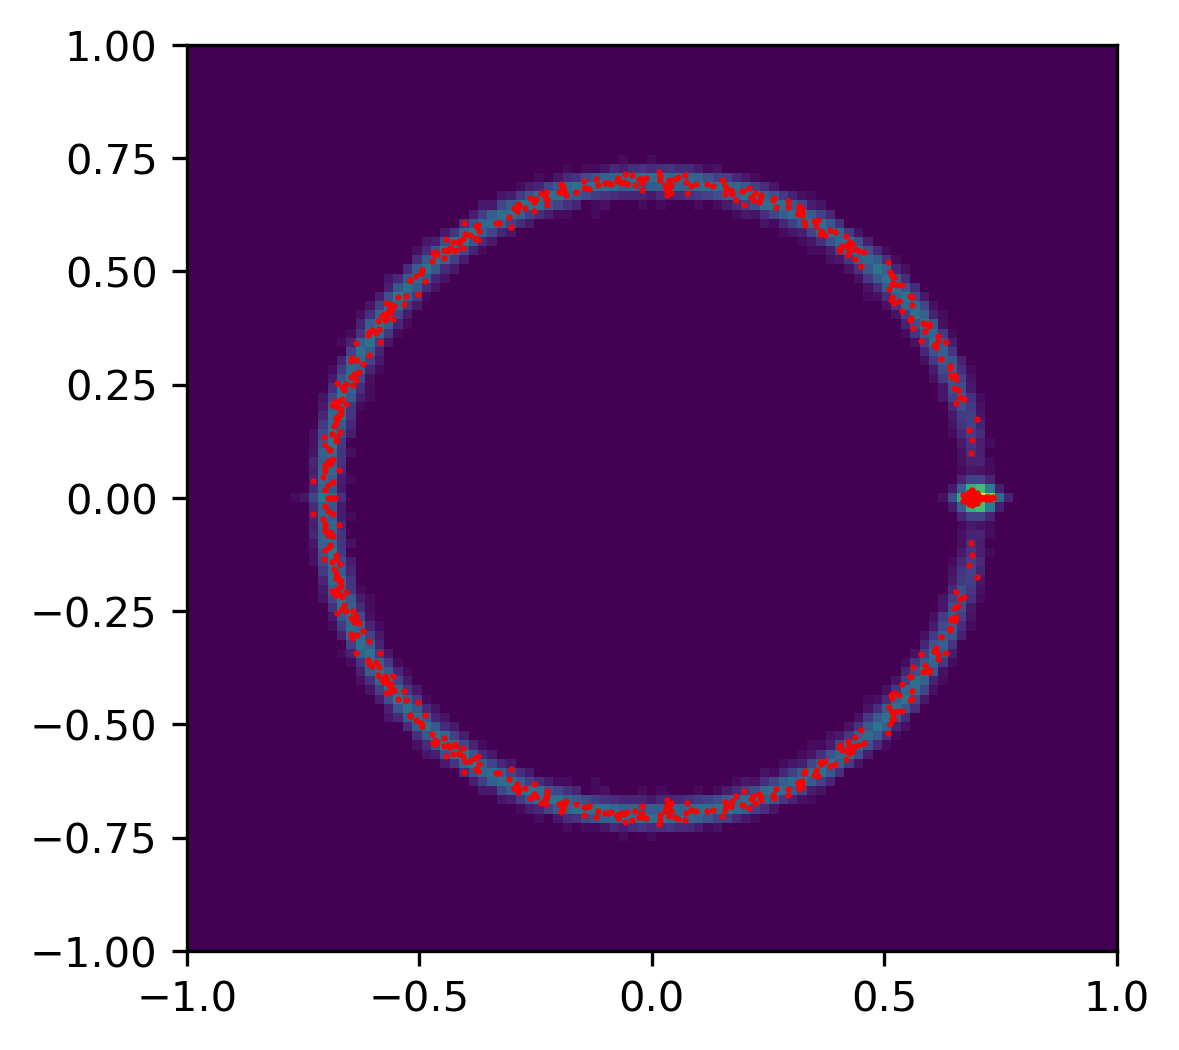

In [34]:
fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample1[:,0], spectrum_resample1[:,1], bins = np.linspace(-1, 1, 100), density=True, norm=mpl.colors.PowerNorm(gamma=0.5))
for spectrum in spectrum_target_list1:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro", markersize=0.5)
plt.savefig(image_path("diluted_fitting_8layer.pdf"), bbox_inches='tight')
plt.show()

In [32]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample_list = []
for diluted_model in tqdm(model_best_list2):
    spectrum_resample = resample_diluted(diluted_model, num_samples = 100, rng=rng)
    spectrum_resample_list.append(spectrum_resample)
    
spectrum_resample2 = np.concatenate(spectrum_resample_list)

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


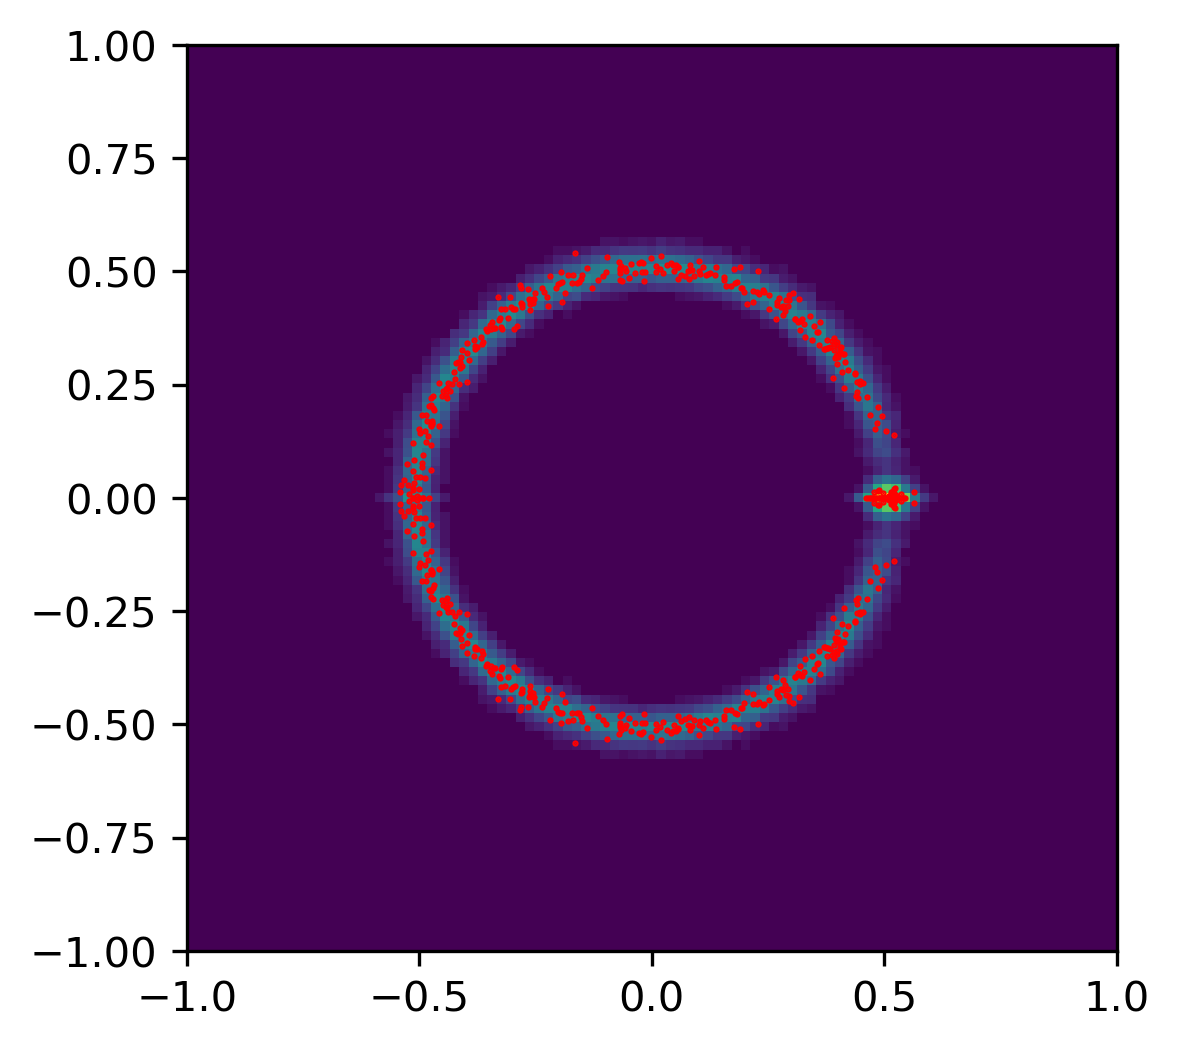

In [39]:
fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample2[:,0], spectrum_resample2[:,1], bins = np.linspace(-1, 1, 100), norm=mpl.colors.PowerNorm(gamma=0.5))
for spectrum in spectrum_target_list2:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro", markersize=0.5)

plt.savefig(image_path("diluted_fitting_16layer.pdf"), bbox_inches='tight')
plt.show()

In [35]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample_list = []
for diluted_model in tqdm(model_best_list3):
    spectrum_resample = resample_diluted(diluted_model, num_samples = 100, rng=rng)
    spectrum_resample_list.append(spectrum_resample)
    
spectrum_resample3 = np.concatenate(spectrum_resample_list)

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


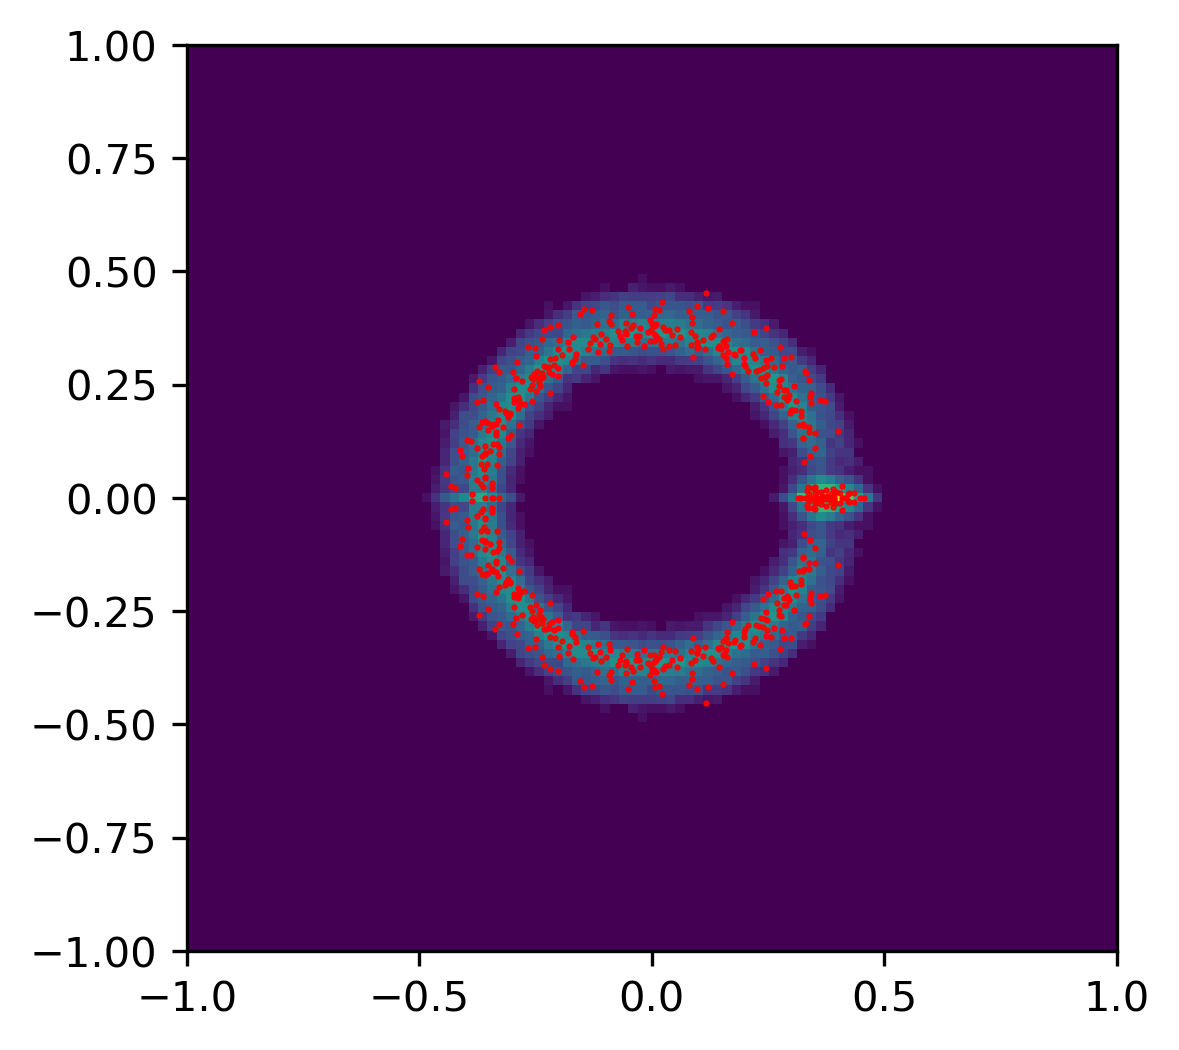

In [38]:
fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample3[:,0], spectrum_resample3[:,1], bins = np.linspace(-1, 1, 100), norm=mpl.colors.PowerNorm(gamma=0.5))
for spectrum in spectrum_target_list3:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro", markersize=0.5)

plt.savefig(image_path("diluted_fitting_24layer.pdf"), bbox_inches='tight')
plt.show()

In [41]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample_list = []
for diluted_model in tqdm(model_best_list4):
    spectrum_resample = resample_diluted(diluted_model, num_samples = 100, rng=rng)
    spectrum_resample_list.append(spectrum_resample)
    

spectrum_resample4 = np.concatenate(spectrum_resample_list)

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


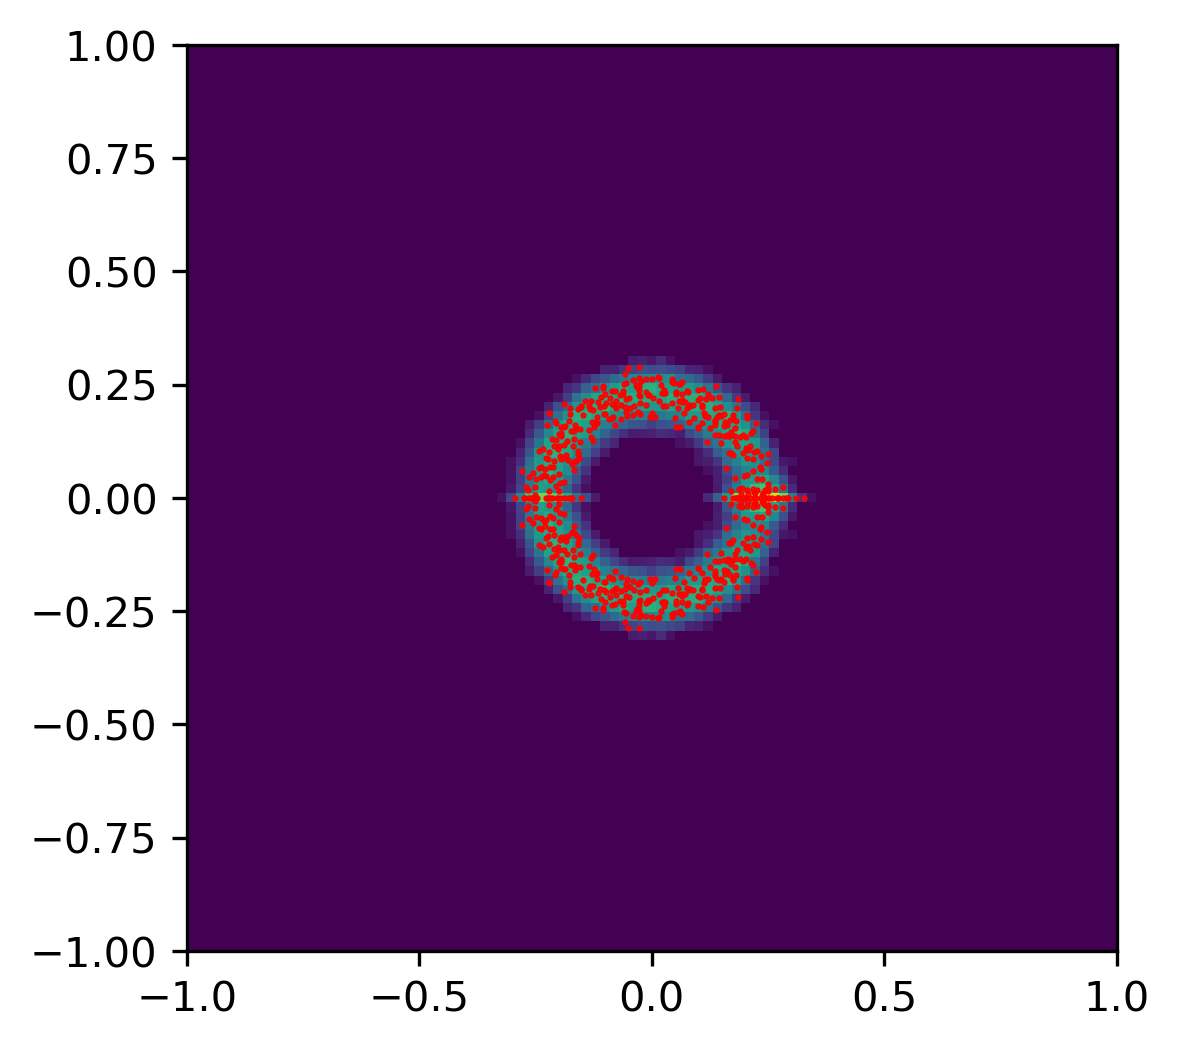

In [42]:
fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample4[:,0], spectrum_resample4[:,1], bins = np.linspace(-1, 1, 100), norm=mpl.colors.PowerNorm(gamma=0.5))
for spectrum in spectrum_target_list4:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro", markersize=0.5)

plt.savefig(image_path("diluted_fitting_32layer.pdf"), bbox_inches='tight')
plt.show()

## Four Qubits, Repetition

In [7]:
[model1, model2, model3, model4, model5] = loader(path1 + "belem_4qubit_repeated.model")

spectrum1 = channel_spectrum(model1.channel, keep_unity=False)
spectrum2 = channel_spectrum(model2.channel, keep_unity=False) 
spectrum3 = channel_spectrum(model3.channel, keep_unity=False)
spectrum4 = channel_spectrum(model4.channel, keep_unity=False)
spectrum5 = channel_spectrum(model5.channel, keep_unity=False)


[distance1, diluted1] = loader(path2 + "diluted_fitting_4qubit_8layer.model")

[distance2, diluted2] = loader(path2 + "diluted_fitting_4qubit_16layer.model")

[distance3, diluted3] = loader(path2 + "diluted_fitting_4qubit_24layer.model")

[distance4, diluted4] = loader(path2 + "diluted_fitting_KL_4qubit_32layer.model")

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Program Files\Anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


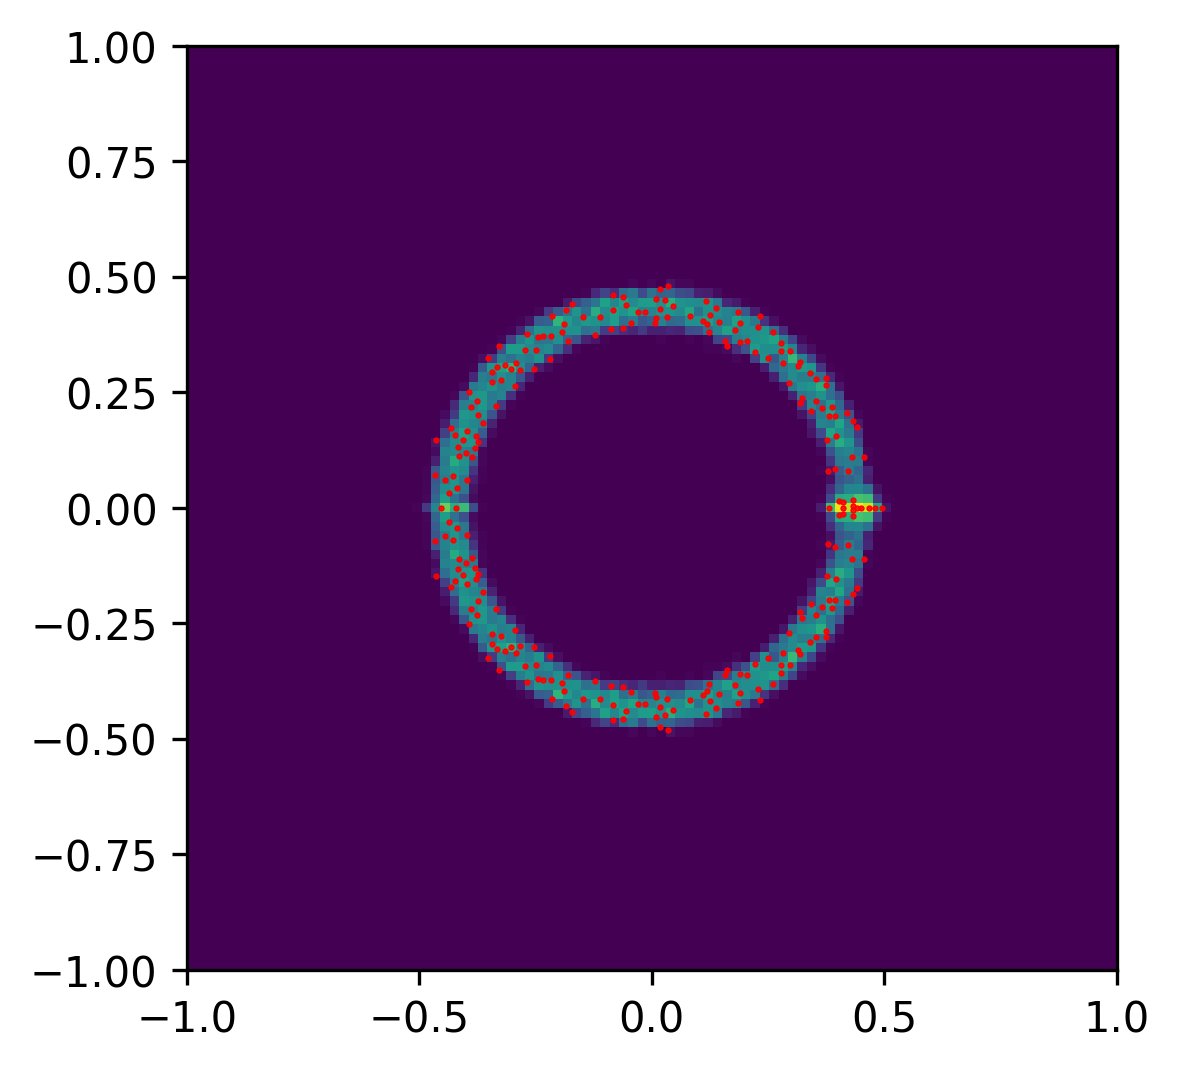

In [8]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample = resample_diluted(diluted1, num_samples = 100, rng=rng)

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 100), norm=mpl.colors.PowerNorm(gamma=1))
plt.plot(spectrum1[:,0], spectrum1[:,1], "ro", markersize=0.5)
plt.savefig("figures/" + "diluted_fitting_4qubit_8layer.pdf", bbox_inches='tight')
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

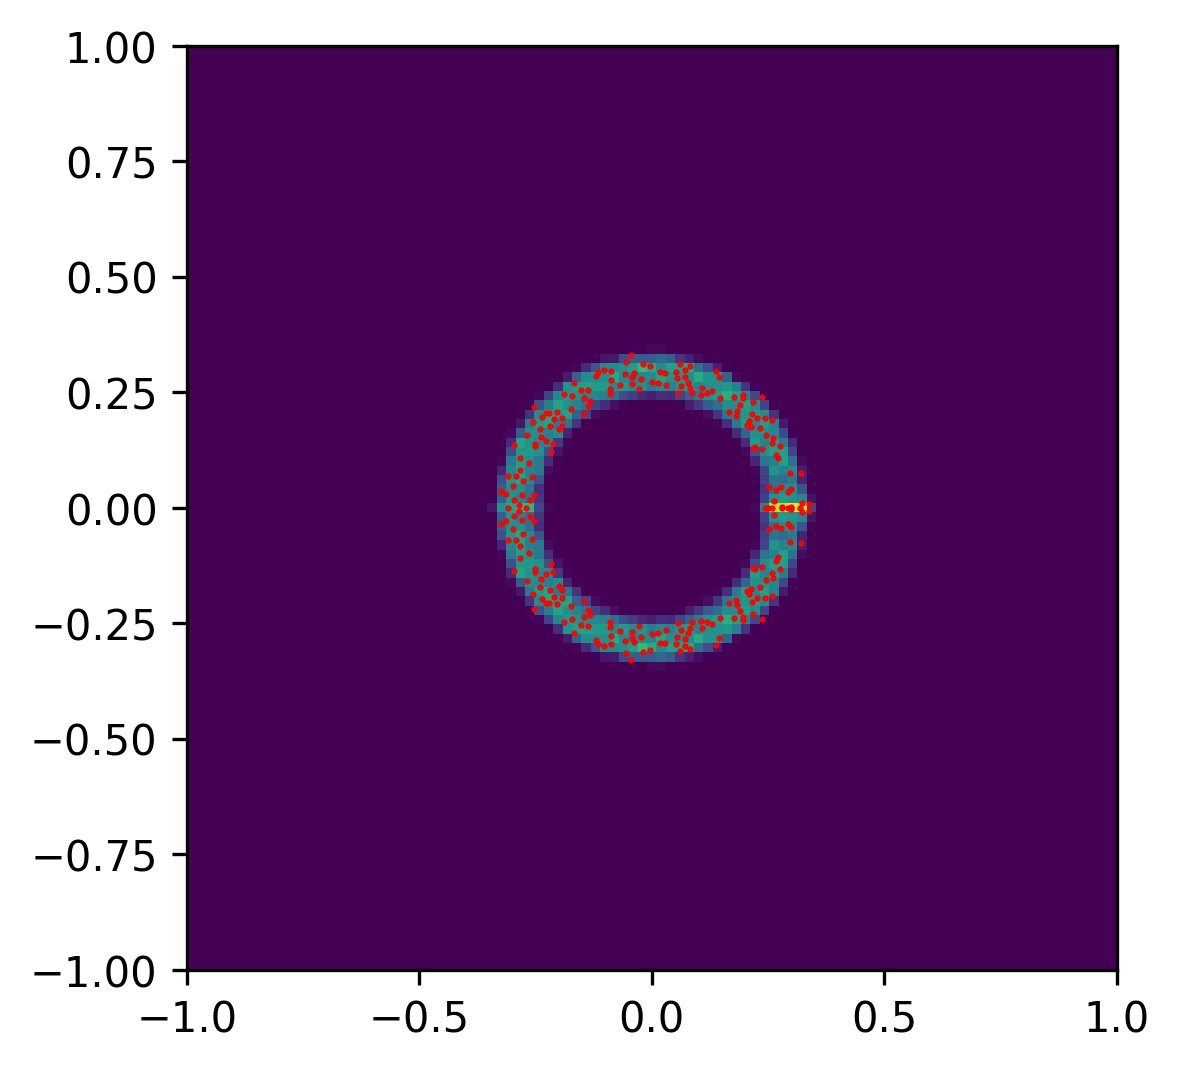

In [6]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample = resample_diluted(diluted2, num_samples = 100, rng=rng)

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 100), norm=mpl.colors.PowerNorm(gamma=1))
plt.plot(spectrum2[:,0], spectrum2[:,1], "ro", markersize=0.5)
plt.savefig("figures/" + "diluted_fitting_KL_4qubit_16layer.pdf", bbox_inches='tight')
plt.show()


c:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


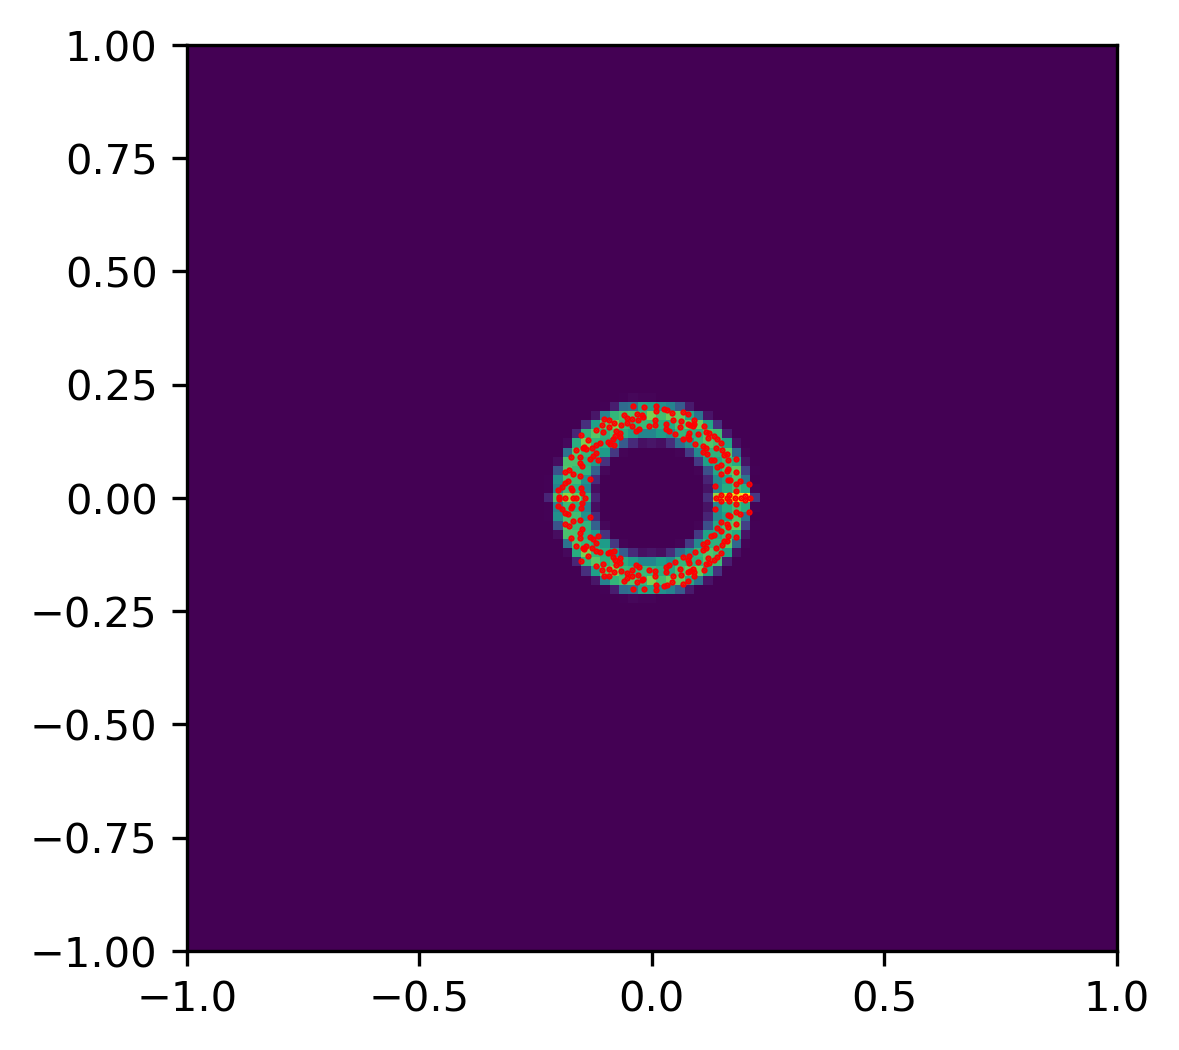

In [11]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)


spectrum_resample = resample_diluted(diluted3, num_samples = 100, rng=rng)

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 100), norm=mpl.colors.PowerNorm(gamma=1))
plt.plot(spectrum3[:,0], spectrum3[:,1], "ro", markersize=0.5)
plt.savefig("figures/" + "diluted_fitting_4qubit_24layer.pdf", bbox_inches='tight')
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Program Files\Anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


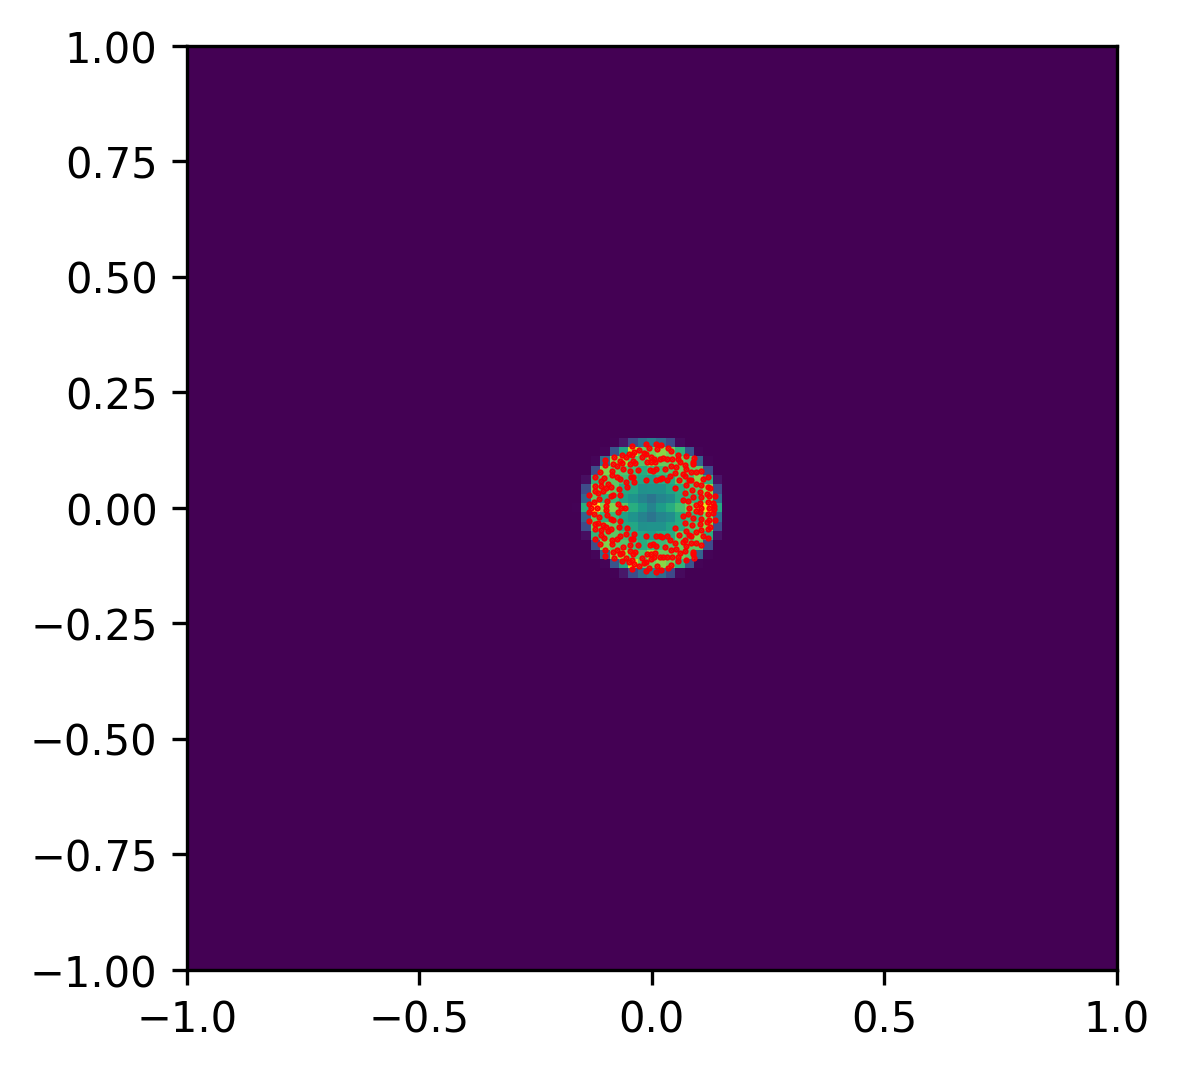

In [9]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample = resample_diluted(diluted4, num_samples = 100, rng=rng)

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 100), norm=mpl.colors.PowerNorm(gamma=1))
plt.plot(spectrum4[:,0], spectrum4[:,1], "ro", markersize=0.5)
#plt.savefig("figures/" + "diluted_fitting_4qubit_32layer.pdf", bbox_inches='tight')
plt.show()


## Four Qubits, Delay

In [47]:
n = 4
d = 2**n

[model1, model2, model3, model4, model5, model6, model7, model8, model9] = loader(path1 + "belem_4qubit_delay.model")

spectrum1 = np.real(channel_spectrum(model1.channel, keep_unity=False))
spectrum2 = np.real(channel_spectrum(model2.channel, keep_unity=False))
spectrum3 = np.real(channel_spectrum(model4.channel, keep_unity=False))
spectrum4 = np.real(channel_spectrum(model6.channel, keep_unity=False))

spectrum1 = spectrum1[spectrum1[:,1]>=0]
spectrum2 = spectrum2[spectrum2[:,1]>=0]
spectrum3 = spectrum3[spectrum3[:,1]>=0]
spectrum4 = spectrum4[spectrum4[:,1]>=0]

[distance1, diluted1] = loader(path2 + "diluted_fitting_4qubit_0delay.model")
[distance2, diluted2] = loader(path2 + "diluted_fitting_4qubit_5delay.model")
[distance3, diluted3] = loader(path2 + "diluted_fitting_4qubit_10delay.model")
[distance4, diluted4] = loader(path2 + "diluted_fitting_4qubit_12_5delay.model")


In [48]:
print(distance1, distance2, distance3, distance4)

0.0041204841226500505 0.001863246488379957 0.009643465250119252 0.012072362215487242


  0%|          | 0/100 [00:00<?, ?it/s]

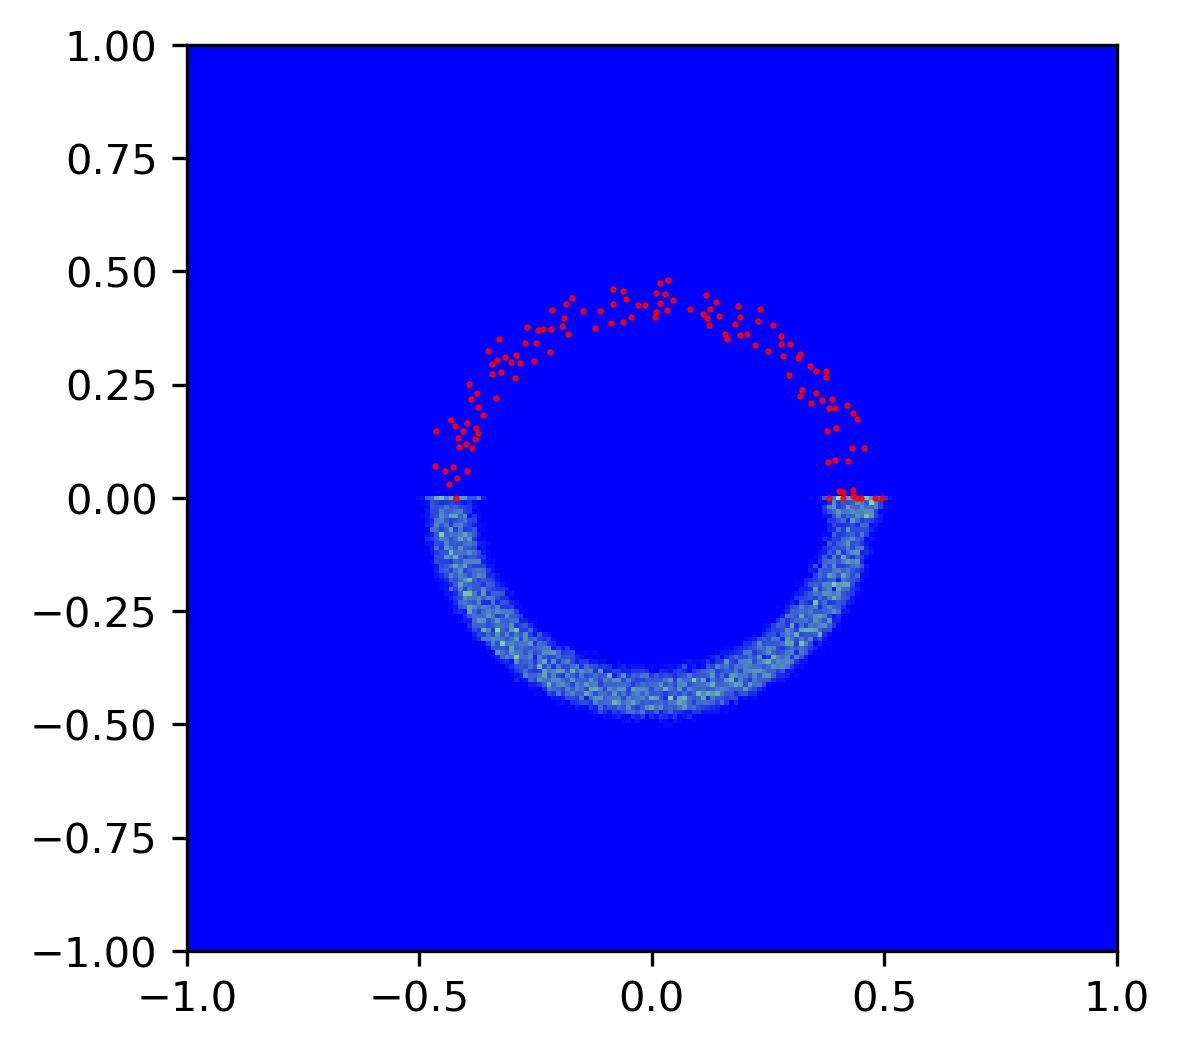

In [36]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample = resample_diluted(diluted1, num_samples = 100, rng=rng)
spectrum_resample = spectrum_resample[spectrum_resample[:,1] <= 0]

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

#linear cmap from blue to green
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, 'blue'), (1, 'lightgreen')])
plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 200), cmap=cmap)
plt.plot(spectrum1[:,0], spectrum1[:,1], "ro", markersize=0.5)
plt.savefig("figures/" + "diluted_fitting_4qubit_0delay.pdf", bbox_inches='tight')
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

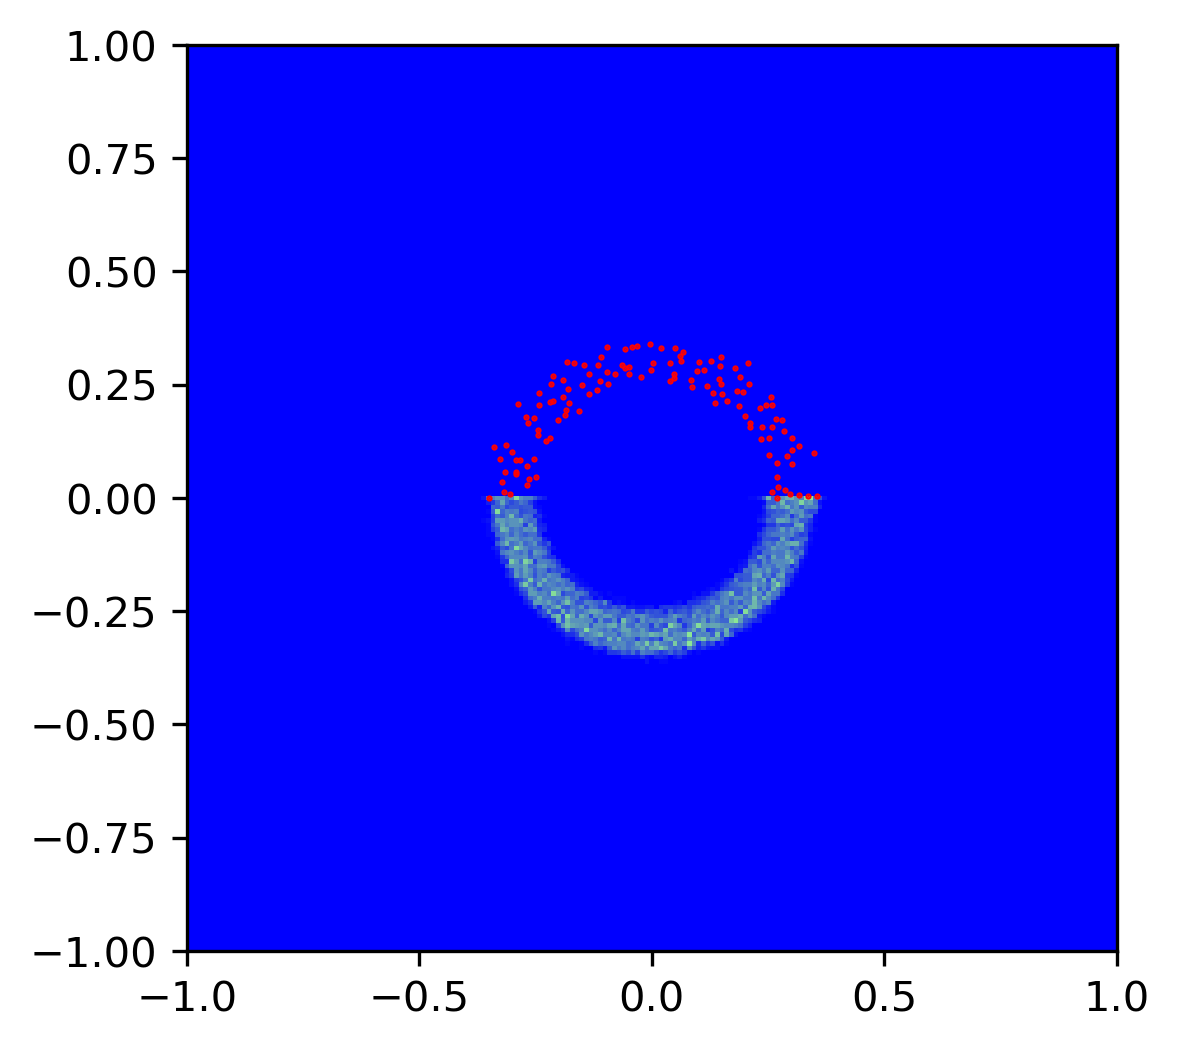

In [37]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample = resample_diluted(diluted2, num_samples = 100, rng=rng)
spectrum_resample = spectrum_resample[spectrum_resample[:,1] <= 0]

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, 'blue'), (1, 'lightgreen')])
plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 200), cmap=cmap)
plt.plot(spectrum2[:,0], spectrum2[:,1], "ro", markersize=0.5)
plt.savefig("figures/" + "diluted_fitting_4qubit_5delay.pdf", bbox_inches='tight')
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

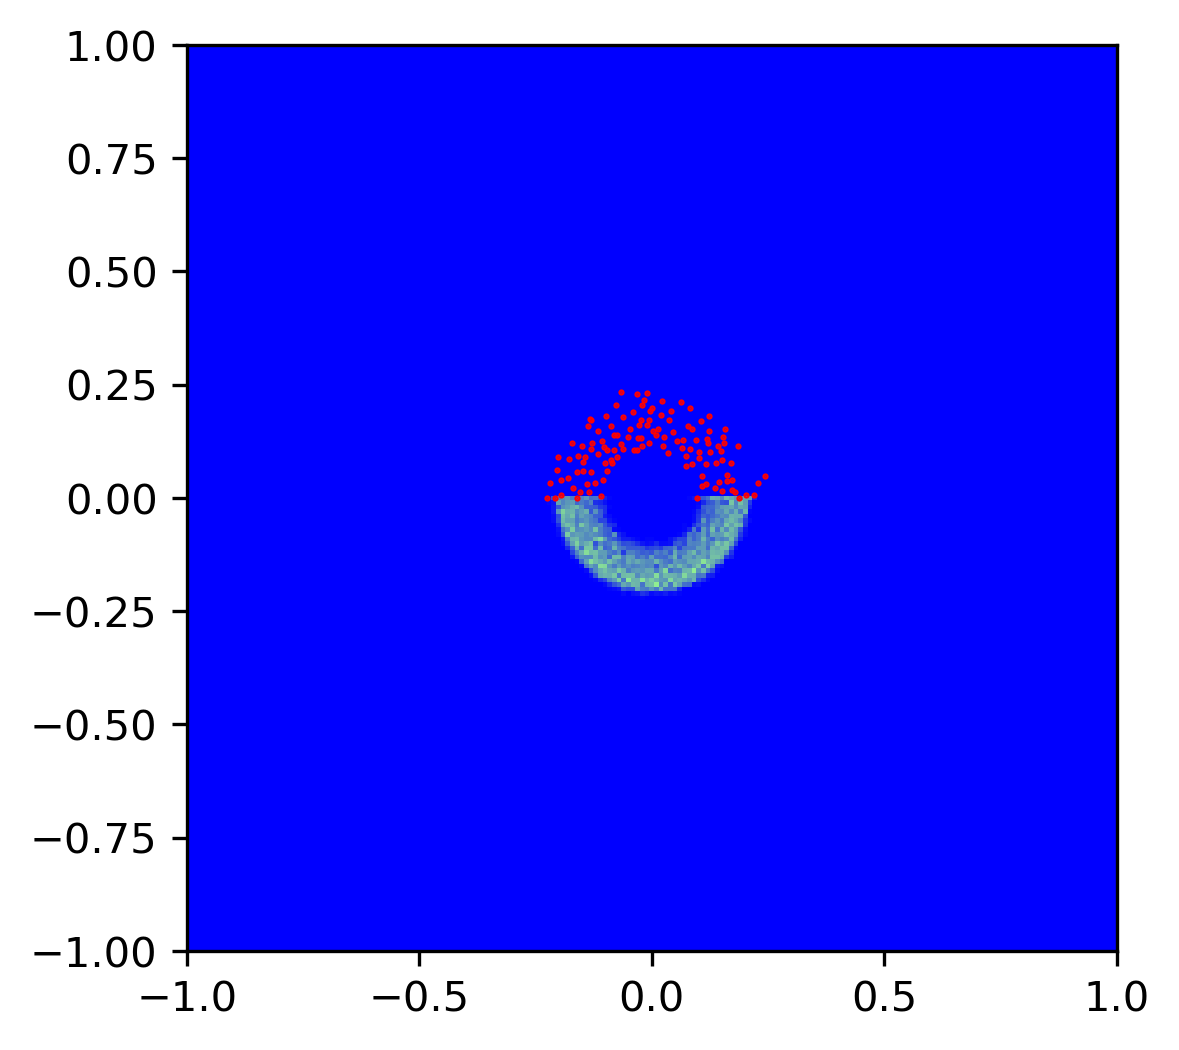

In [40]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample = resample_diluted(diluted3, num_samples = 100, rng=rng)
spectrum_resample = spectrum_resample[spectrum_resample[:,1] <= 0]

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, 'blue'), (1, 'lightgreen')])
plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 200), cmap=cmap)
plt.plot(spectrum3[:,0], spectrum3[:,1], "ro", markersize=0.5)
plt.savefig("figures/" + "diluted_fitting_4qubit_10delay.pdf", bbox_inches='tight')
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 1200x1200 with 0 Axes>

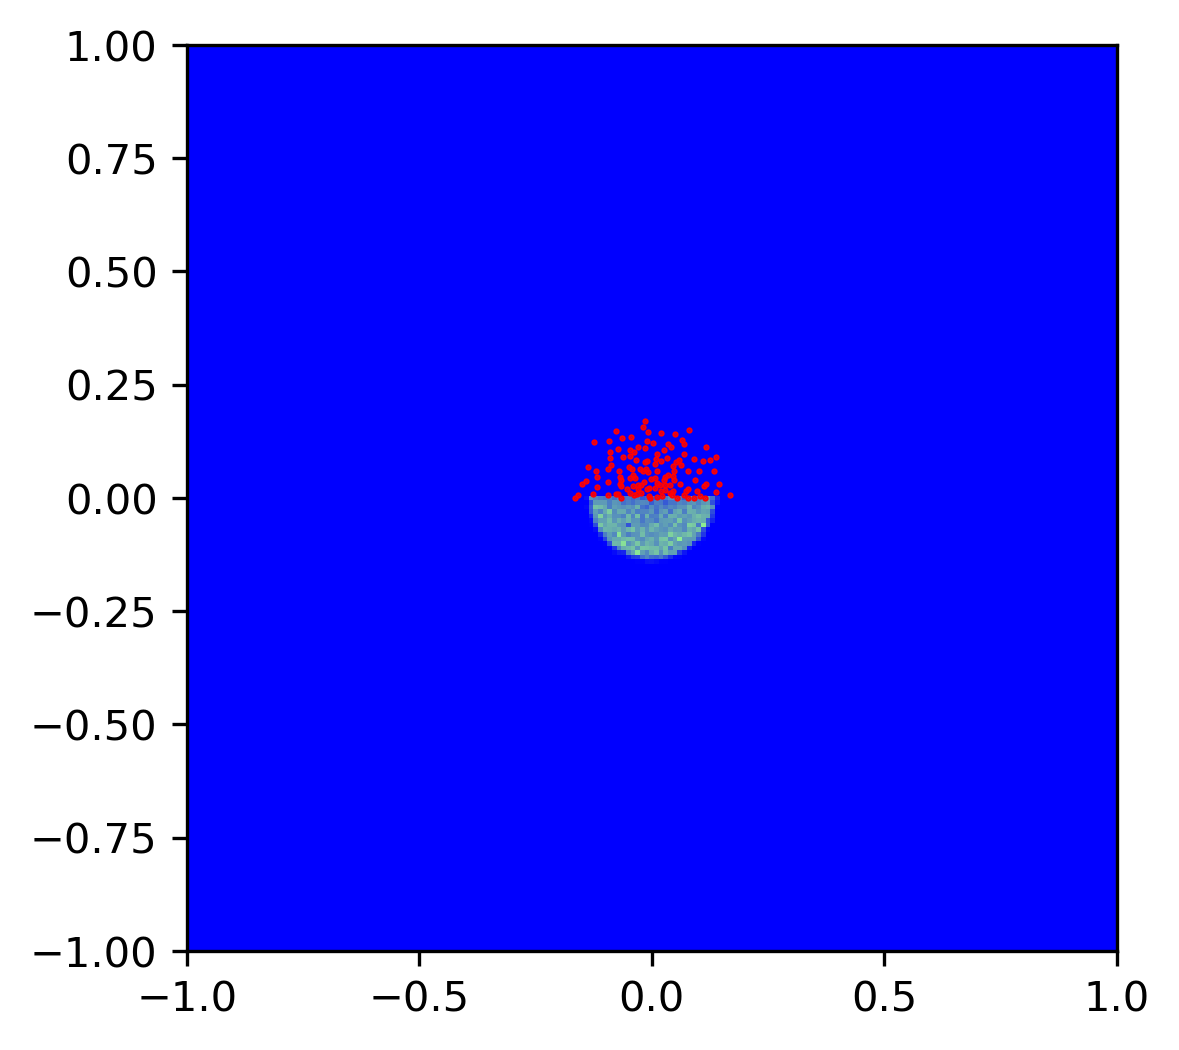

In [50]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample = resample_diluted(diluted4, num_samples = 100, rng=rng)
spectrum_resample = spectrum_resample[spectrum_resample[:,1] <= 0]

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, 'blue'), (1, 'lightgreen')])
plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 200), cmap=cmap)
plt.plot(spectrum4[:,0], spectrum4[:,1], "ro", markersize=0.5)
plt.savefig("figures/" + "diluted_fitting_4qubit_12_5delay.pdf", bbox_inches='tight')
plt.show()


## Test

0.013338428565931457
(0.12204123486369145+0j) 0.021856573652384453 (0.10874949096576494+0j) 0.0218098889843795


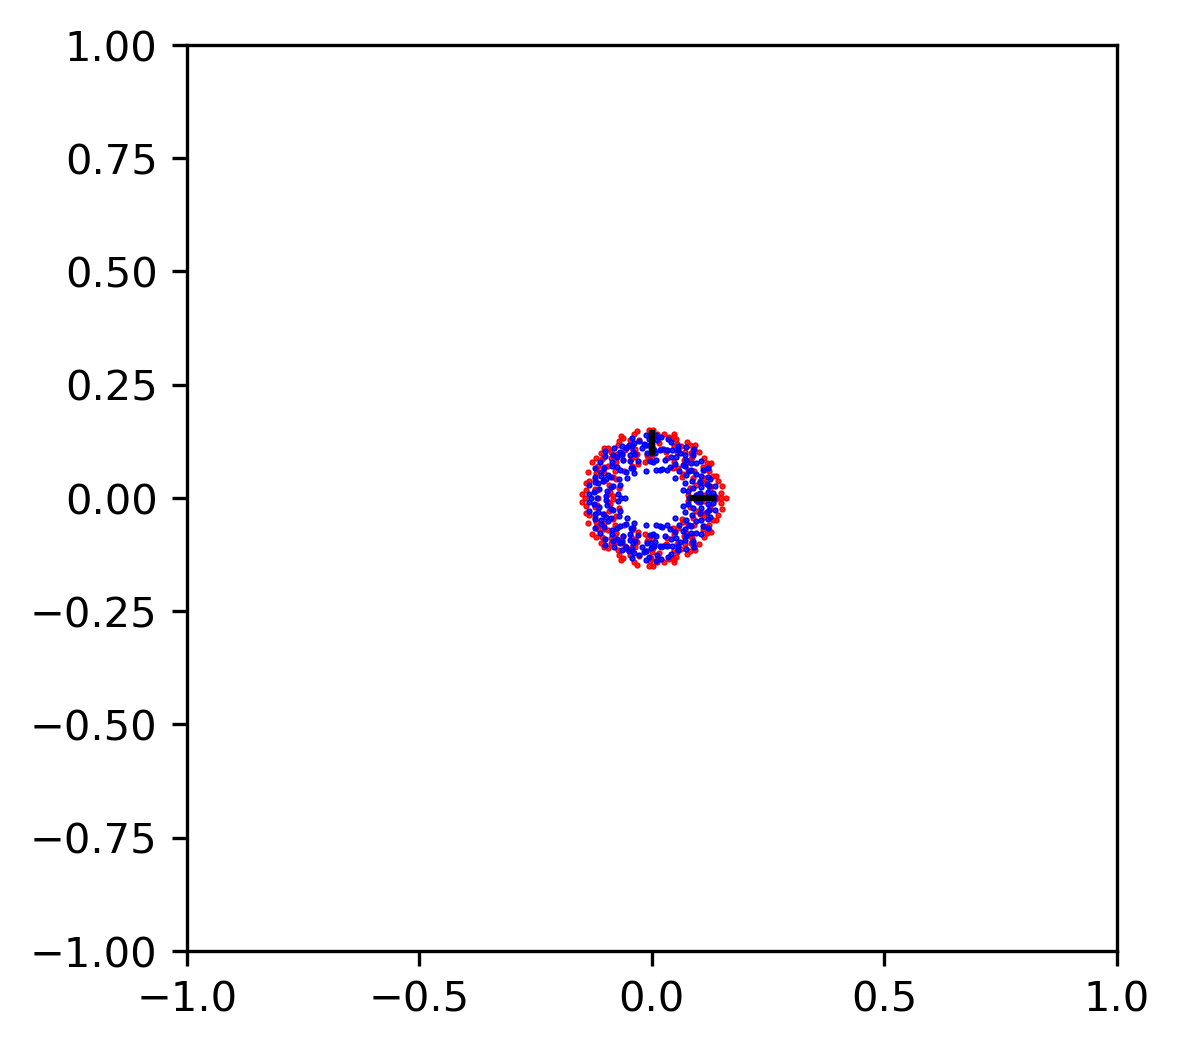

In [19]:
# set seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

radial = spectrum_to_radial(spectrum4)

r_mean1 = np.mean(radial)
r_std1 = np.std(radial)

quantum_channel = DilutedKrausMap(U=generate_unitary(2**4), 
                                  c=0.12, 
                                  kraus_part=KrausMap(2**4, 
                                                      rank=86, 
                                                      trainable=False))

spectrum = channel_spectrum(quantum_channel, keep_unity=False)
radial = spectrum_to_radial(spectrum)
r_mean = np.mean(radial)
r_std = np.std(radial)

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.plot(spectrum[:,0], spectrum[:,1], "ro", markersize=0.5)
plt.plot(spectrum4[:,0], spectrum4[:,1], "bo", markersize=0.5)
plt.plot([r_mean1 - r_std1, r_mean1 + r_std1], [0, 0], "k-")
plt.plot([0, 0], [r_mean - r_std, r_mean + r_std], "k-")

print(np.abs(r_mean1 - r_mean) + np.abs(r_std1 - r_std))
print(r_mean, r_std, r_mean1, r_std1)